HAD(3)
HAD(1)
CNOT(1,3)
CNOT(0,2)
T(3)
CNOT(2,1)
CNOT(3,1)
CNOT(0,1)
HAD(0)
CNOT(1,0)
CNOT(3,2)
T(2)
CNOT(2,0)
CNOT(2,0)
CNOT(2,1)
CNOT(0,3)
CNOT(0,2)
CNOT(1,2)
CNOT(3,2)
CNOT(0,3)


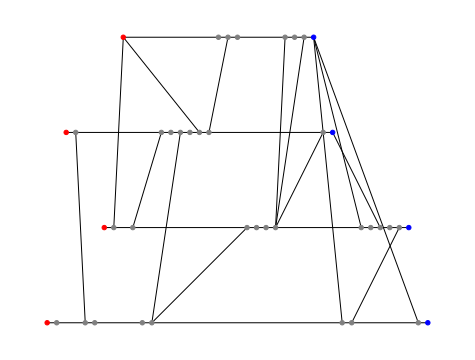

In [1]:
from JCZCircuit import *
import pyzx as zx
import networkx as nx

NQubit = 4
Depth = 20

def generate_circuit():
    circuit = zx.generate.CNOT_HAD_PHASE_circuit(qubits=NQubit,depth=Depth)
    # print(circuit.gates)
    qubits = []
    for i in range(NQubit):
        qubits.append(i)
    jcz_circuit = JCZCircuit()
    jcz_circuit.qubits_init(qubits)
    for gate in circuit.gates:
        # print(gate)
        if gate.name == "HAD":
            jcz_circuit.add_H(int(str(gate)[4:-1]))
        elif gate.name == "CNOT":
            gate_split = str(gate).split(',')
            qubit1 = int(gate_split[0][5:])
            qubit2 = int(gate_split[1][0:-1])
            jcz_circuit.add_CNOT(qubit1, qubit2)
        elif gate.name == "T":
            jcz_circuit.add_T(int(str(gate)[2:-1]))

    # zx.draw(circuit)
    # gates_list = [CZGate(0, 2), JGate(0, 1), CZGate(0, 1), CZGate(0, 1), CZGate(0, 1), JGate(1, 3), JGate(1, 2)]

    return  jcz_circuit.gates, NQubit

# using pyzx to help draw cz j circuit, assume xphase to be j phase
def show_circuit(qubits, gates_list):
    c = zx.Circuit(qubit_amount=qubits)
    for gate in gates_list:
        if gate.type() == "J":
            c.add_gate("XPhase", gate.qubit, phase = gate.phase / 4)
        else:
            c.add_gate("CZ", gate.qubit1, gate.qubit2)
    zx.draw(c)
    return

def turn_to_graph(gates_list, qubits):
    node_index = 0
    pos_x = 0
    pre_nodes = {}
    CZ_consecutive_path = []
    for q in range(qubits):
        pre_nodes[q] = -1

    graph = nx.Graph()
    for gate in gates_list:
        # CZ_consecutive_path.clear()
        if gate.type() == "J":
            qubit = gate.qubit
            if qubit in CZ_consecutive_path:
                CZ_consecutive_path.clear()
            if pre_nodes[gate.qubit] == -1:
                graph.add_node(node_index, node_val = "In", pos = (pos_x, - qubit))
                graph.add_node(node_index + 1, node_val = "Out", pos  = (pos_x + 1, - qubit))
                graph.add_edge(node_index, node_index + 1)
                qubit = gate.qubit
                pre_nodes[qubit] = node_index + 1
                pos_x += 2
                node_index += 2
            else:
                pre_node = pre_nodes[gate.qubit]
                if graph.nodes[pre_node]['node_val'] == "Out":
                    graph.nodes[pre_node]['node_val'] = "Aux"
                else:
                    graph.nodes[pre_node]['node_val'] = "In"
                qubit = gate.qubit
                graph.add_node(node_index, node_val = "Out", pos = (pos_x, - qubit))
                graph.add_edge(pre_node, node_index)
                pre_nodes[qubit] = node_index
                pos_x += 1
                node_index += 1
        else:
            qubit1 = gate.qubit1
            qubit2 = gate.qubit2
            if pre_nodes[qubit1] == -1:
                graph.add_node(node_index, node_val = "IO", pos = (pos_x, - qubit1))
                pre_nodes[qubit1] = node_index
                node_q1 = node_index
                pos_x += 1
                node_index += 1
            else:
                node_q1 = pre_nodes[qubit1]
            
            if pre_nodes[qubit2] == -1:
                graph.add_node(node_index, node_val = "IO", pos = (pos_x, - qubit2))
                pre_nodes[qubit2] = node_index
                node_q2 = node_index
                pos_x += 1
                node_index += 1
            else:
                node_q2 = pre_nodes[qubit2]
            
            if node_q1 in CZ_consecutive_path and node_q2 in CZ_consecutive_path:
                # print("hello")
                pos_x1 = graph.nodes[node_q1]['pos'][0]
                pos_x2 = graph.nodes[node_q2]['pos'][0]
                node_size = len(CZ_consecutive_path)
                graph.add_node(node_index, node_val = "Aux", pos = (0, 0))
                graph.remove_edge(CZ_consecutive_path[-1], CZ_consecutive_path[-2])
                graph.add_edge(CZ_consecutive_path[-2], node_index)
                graph.add_edge(node_index, CZ_consecutive_path[-1])
                remove_node = CZ_consecutive_path[-1]
                CZ_consecutive_path.remove(remove_node)
                CZ_consecutive_path.append(node_index)
                CZ_consecutive_path.append(remove_node)
                node_i = 1
                # print ("aux nodes", CZ_consecutive_path[1: -1])
                for nnode in CZ_consecutive_path[1: -1]:
                    graph.nodes[nnode]['pos'] = ((pos_x2 - pos_x1) / node_size * node_i  + pos_x1, - (qubit2 - qubit1) / node_size * node_i - qubit1)
                    node_i += 1
                node_index += 1
            else:    
                # print("hello1")
                graph.add_edge(node_q1, node_q2)
                CZ_consecutive_path.clear()
                CZ_consecutive_path.append(node_q1)
                CZ_consecutive_path.append(node_q2)
            # print(CZ_consecutive_path)

    return graph

def main():
    gates_list, qubits = generate_circuit()
    show_circuit(qubits, gates_list)
    graph= turn_to_graph(gates_list, qubits)
    colors = []
    for nnode in graph.nodes():
        if graph.nodes[nnode]['node_val'] == "Out":
            colors.append('blue')
        elif graph.nodes[nnode]['node_val'] == "In":
            colors.append('red')
        elif graph.nodes[nnode]['node_val'] == "IO":
            colors.append('green')
        else:
            colors.append('gray')
    labels = nx.get_node_attributes(graph, 'node_val')
    node_pos = nx.get_node_attributes(graph, 'pos')
    nx.draw(graph, pos = node_pos, node_color = colors, node_size = 20)
    return

if __name__ == '__main__':
    main()